In [1]:
#Utilities

import pandas as pd 
import numpy as np
import spacy
import string
import re
#Plotting

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
#Importing the dataset
    
df=pd.read_csv("Tweets.csv")
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.700000e+17,Neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24-02-2015 11:35,NaN,Eastern Time (US & Canada)
1,5.700000e+17,Positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
2,5.700000e+17,Neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24-02-2015 11:15,Lets Play,Central Time (US & Canada)
3,5.700000e+17,Negetive,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
4,5.700000e+17,Negetive,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)
5,5.700000e+17,Negetive,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)
6,5.700000e+17,Positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,24-02-2015 11:13,San Francisco CA,Pacific Time (US & Canada)
7,5.700000e+17,Neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,24-02-2015 11:12,Los Angeles,Pacific Time (US & Canada)
8,5.700000e+17,Positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,24-02-2015 11:11,San Diego,Pacific Time (US & Canada)
9,5.700000e+17,Positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,24-02-2015 10:53,Los Angeles,Eastern Time (US & Canada)


In [3]:
#Shape of the dataset

df.shape

(14640, 15)

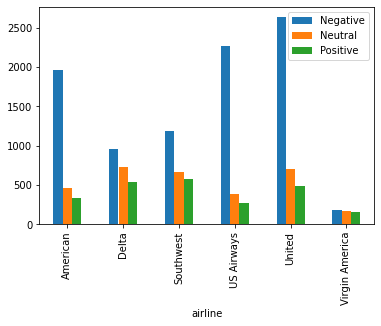

In [4]:
#Plotting the distribution of dataset

airline_sentiment = df.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar',legend = False)
l = plt.legend(('Negative','Neutral','Positive'), loc='best')

In [5]:
trim_df=df.drop(df[df['airline_sentiment']=='Neutral'].index,axis=0)
trim_df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,5.700000e+17,Positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
3,5.700000e+17,Negetive,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
4,5.700000e+17,Negetive,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)
5,5.700000e+17,Negetive,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)
6,5.700000e+17,Positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,24-02-2015 11:13,San Francisco CA,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14633,5.700000e+17,Negetive,1.0000,Cancelled Flight,1.0000,American,NaN,RussellsWriting,NaN,0,@AmericanAir my flight was Cancelled Flightled...,NaN,22-02-2015 12:01,Los Angeles,Arizona
14634,5.700000e+17,Negetive,0.6684,Late Flight,0.6684,American,NaN,GolfWithWoody,NaN,0,@AmericanAir right on cue with the delays👌,NaN,22-02-2015 12:01,NaN,Quito
14635,5.700000e+17,Positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,22-02-2015 12:01,NaN,NaN
14636,5.700000e+17,Negetive,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,22-02-2015 11:59,Texas,NaN


In [28]:
#Converting catagorical values into numeric data

trim_df['airline_sentiment'].replace(['Negetive', 'Positive'],
                        [0, 1], inplace=True)
trim_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,5.700000e+17,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
3,5.700000e+17,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
4,5.700000e+17,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)
5,5.700000e+17,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)
6,5.700000e+17,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,24-02-2015 11:13,San Francisco CA,Pacific Time (US & Canada)


In [29]:
#Selecting the setected column for further processing

data = trim_df[['airline_sentiment','text']]

In [30]:
#Cheking data

data

,airline_sentiment,text
1,1,@VirginAmerica plus you've added commercials t...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...
5,0,@VirginAmerica seriously would pay $30 a fligh...
6,1,"@VirginAmerica yes, nearly every time I fly VX..."
...,...,...
14633,0,@AmericanAir my flight was Cancelled Flightled...
14634,0,@AmericanAir right on cue with the delays👌
14635,1,@AmericanAir thank you we got on a different f...
14636,0,@AmericanAir leaving over 20 minutes Late Flig...


In [31]:
data['airline_sentiment'].value_counts()

0    9178
1    2363
Name: airline_sentiment, dtype: int64

In [33]:
#Checking unique values

data['airline_sentiment'].unique()

array([1, 0], dtype=int64)

In [34]:
#Separating the sentiment

data_pos = data[data['airline_sentiment'] == 1]
data_neg = data[data['airline_sentiment'] == 0]

In [35]:
#taking one fourth data so we can run on our machine easily

data_pos=data_pos.iloc[:int(1000)]
data_neg=data_neg.iloc[:int(1000)]

In [36]:
#Combinig all tweets

dataset=pd.concat([data_pos,data_neg])
dataset

,airline_sentiment,text
1,1,@VirginAmerica plus you've added commercials t...
6,1,"@VirginAmerica yes, nearly every time I fly VX..."
8,1,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,1,"@VirginAmerica it was amazing, and arrived an ..."
11,1,@VirginAmerica I &lt;3 pretty graphics. so muc...
...,...,...
1649,0,@united seriously what's with the slow #wifi o...
1650,0,". @united 5 hours, 3 gates, and 3 planes Late ..."
1651,0,@united your gate attendant had some snobby re...
1652,0,@united Poor cabin luggage service on UA1266 t...


In [37]:
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")
# creating list of stopword by using Spacy

stopwords = list(STOP_WORDS)
# creating list of punctuation marks

punctuations = string.punctuation

In [38]:
#removing special characters

def cleaning_special_character(text):
    return re.sub('[^a-zA-Z]', ' ', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_special_character(x))
dataset['text'].head()  

1      VirginAmerica plus you ve added commercials t...
6      VirginAmerica yes  nearly every time I fly VX...
8        virginamerica Well  I didn t but NOW I DO    D
9      VirginAmerica it was amazing  and arrived an ...
11     VirginAmerica I  lt   pretty graphics  so muc...
Name: text, dtype: object

In [39]:
#Tokanization 

def cleandata(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_  != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = temp.lower_
        tokens.append(temp) 
    
    final_token = []
    for token in tokens:
        if token not in stopwords and token not in punctuations:
            final_token.append(token)
    return final_token      

In [40]:
#Example to check tokanization

cleandata("Hello how are you. Like this video")

['hello', 'like', 'video']

In [41]:


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

In [42]:
#Vectarization

tfidf = TfidfVectorizer(tokenizer=cleandata)
classifier = LinearSVC()

In [43]:
X = dataset['text']
Y = dataset['airline_sentiment']

In [44]:
#Splitting data into training and testing dataset

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state=500)

In [45]:
X_train.shape,X_test.shape

((1600,), (400,))

In [46]:
X_train

4286     united  jsumiyasu I am thankful to the  Unite...
1231     united UA     Flight was a nightmare   From p...
1419     united Apart from being on hold for over   ho...
490      VirginAmerica you guys are perfect as always ...
2768     united all good man it isn t your fault that ...
                              ...                        
1316     united I guess you have to  follow  me in ord...
1528     united They let us know in advance of the reb...
1462     united you really screwed up dealing mechanic...
5740       SouthwestAir Thank you  I can t wait either   
5302           SouthwestAir DM sent  Thanks for the help 
Name: text, Length: 1600, dtype: object

In [47]:
clf = Pipeline([('tfidf',tfidf),('clf',classifier)])

In [48]:
clf.fit(X_train,Y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function cleandata at 0x0000026857CB5AF8>)),
                ('clf', LinearSVC())])

In [49]:
Y_pred = clf.predict(X_test)

In [50]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       196
           1       0.88      0.81      0.84       204

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



[[174  22]
 [ 39 165]]


Text(0.5, 1.0, 'Confusion Matrix')

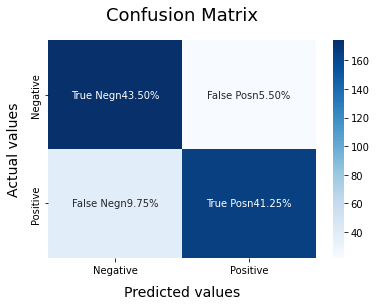

In [51]:
# Compute and plot the Confusion matrix
cf_matrix=confusion_matrix(Y_test, Y_pred)
print(cf_matrix)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [52]:
clf.predict(['Wow this is amazing lession'])

array([1], dtype=int64)

In [53]:
clf.predict(['wow this sucks'])

array([0], dtype=int64)

In [54]:
clf.predict(['It is ok'])

array([1], dtype=int64)

In [58]:
negative_tweets = df[(df['airline_sentiment']=='Negetive')]
negative_tweets.shape

(9178, 15)

In [59]:
worst_airline = negative_tweets[['airline','airline_sentiment_confidence','negativereason']]
worst_airline

,airline,airline_sentiment_confidence,negativereason
3,Virgin America,1.0000,Bad Flight
4,Virgin America,1.0000,Can't Tell
5,Virgin America,1.0000,Can't Tell
15,Virgin America,0.6842,Late Flight
17,Virgin America,1.0000,Bad Flight
...,...,...,...
14631,American,1.0000,Bad Flight
14633,American,1.0000,Cancelled Flight
14634,American,0.6684,Late Flight
14636,American,1.0000,Customer Service Issue


In [60]:
# Create the rank for the worst airline

cnt_worst_airline = worst_airline.groupby('airline', as_index=False).count()
cnt_worst_airline.sort_values('negativereason', ascending=False)

,airline,airline_sentiment_confidence,negativereason
4,United,2633,2633
3,US Airways,2263,2263
0,American,1960,1960
2,Southwest,1186,1186
1,Delta,955,955
5,Virgin America,181,181


In [61]:
# Create the rank for negative reason

motivation = negative_tweets[['airline','negativereason']]
cnt_bad_flight_motivation = motivation.groupby('negativereason', as_index=False).count()
cnt_bad_flight_motivation.sort_values('negativereason', ascending=False)

,negativereason,airline
9,longlines,178
8,Lost Luggage,724
7,Late Flight,1665
6,Flight Booking Problems,529
5,Flight Attendant Complaints,481
4,Damaged Luggage,74
3,Customer Service Issue,2910
2,Cancelled Flight,847
1,Can't Tell,1190
0,Bad Flight,580
